# Vitamix Department-Entity Forecast Models

1. Import packages (use base environment)
_______________________________________________________________

In [20]:
# Packages
import pandas as pd
import numpy as np
import snowflake.connector
import os
from scalecast.Forecaster import Forecaster
#from pmdarima import auto_arima # if we wanted to set orders with pmdarima’s auto_arima function
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer

2. Load Data
_______________________________________________________________

##### To Do: copy and paste in to a new chunk, enter credentials and run to save in environment. Then delete chunk
%env snowflakeuser=<your_snowflake_username> <br>
%env snowflakepass=<your_snowflake_password>

In [14]:
# Query Snowflake

# Snowflake connection parameters
connection_params = {
    "user": os.environ['snowflakeuser'],
    "password": os.environ['snowflakepass'],
    "account": "zib52348.us-east-1",
    "role": "ACCOUNTADMIN",
    "warehouse": "REPORTING",
    "database": "ANALYTICS",
    "schema": "FORECASTING",
}

# Establish a connection to Snowflake
conn = snowflake.connector.connect(**connection_params)

with open('net_sales_query.sql', 'r') as query:
    # connection == the connection to your database, in your case prob_db
    df_in = pd.read_sql_query(query.read(),conn)

# Close the connection
conn.close()

C:\Users\crudek\AppData\Local\Temp\ipykernel_1604\3034601435.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_in = pd.read_sql_query(query.read(),conn)


3. Time Series Forecasting
_______________________________________________________________

# Net Sales Forecasting

* ARIMA only using scalecast
* Grid search the optimal orders in scalecast

[Documentation](https://towardsdatascience.com/forecast-with-arima-in-python-more-easily-with-scalecast-35125fc7dc2e#:~:text=An%20Autoregressive%20Integrated%20Moving%20Average,statistical%20properties%20of%20the%20data.)

[Scalecast](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html)

In [17]:
### 1. Data prep ###

df = df_in

df["MONTH"] = pd.to_datetime(df["MONTH"]) # convert month field to date
#df_all = result_df[result_df['MONTH'] <= pd.Timestamp(2023,6,1)] # we have data through July '23 when we are training these models. 

df = df[df['MONTH'] <= pd.Timestamp(2023,6,1)] # ***** ADJUSTABLE *****

#Some random months will have data that we want to remove (* Want to test without July though)
df = df[["DEP_ENT", "MONTH", "NET_SALES"]] # select fields of interest
df = df.sort_values(['DEP_ENT', 'MONTH']) # reorder dataframe


### 2. Spot checks ###

# check data types
print(df.dtypes)
print("-----")

# check the unique time_series. 14 different department-entity combinations
print(df['DEP_ENT'].nunique())
print("-----")

# check how many months for each dep-ent. 3 dep-ent do not have all months of data
print(df.groupby(['DEP_ENT']).size())
print("-----")

# check for nulls. No nulls
print(df.isnull().sum())

DEP_ENT              object
MONTH        datetime64[ns]
NET_SALES           float64
dtype: object
-----
14
-----
DEP_ENT
160_155    90
170_155    90
200_155    90
200_310    90
210_155    90
210_165    90
210_310    90
220_155    90
220_310    84
240_155    90
250_155    90
250_165    56
250_310    90
260_155    53
dtype: int64
-----
DEP_ENT      0
MONTH        0
NET_SALES    0
dtype: int64


In [51]:
### TEMP - just one department ###

# test data
df_1 = df[df["DEP_ENT"] == '200_155']
# trim
df_1_trim = df_1[['MONTH', 'NET_SALES']]
# create series
df_1_s = df_1_trim.set_index('MONTH')['NET_SALES']
# set frequency of series
df_1_s = df_1_s.asfreq('MS') 
# convert back to dataframe
df_1_d = df_1_s.to_frame()
# impute
mean_imputer = SimpleImputer(strategy='mean')
df_1_d['NET_SALES'] = mean_imputer.fit_transform(df_1_d['NET_SALES'].values.reshape(-1,1))
#reset index
df_1_d.reset_index(inplace=True)

c:\Users\crudek\AppData\Local\anaconda3\Lib\site-packages\scalecast\_utils.py:60: Warning: Confidence intervals not found for arima1. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(


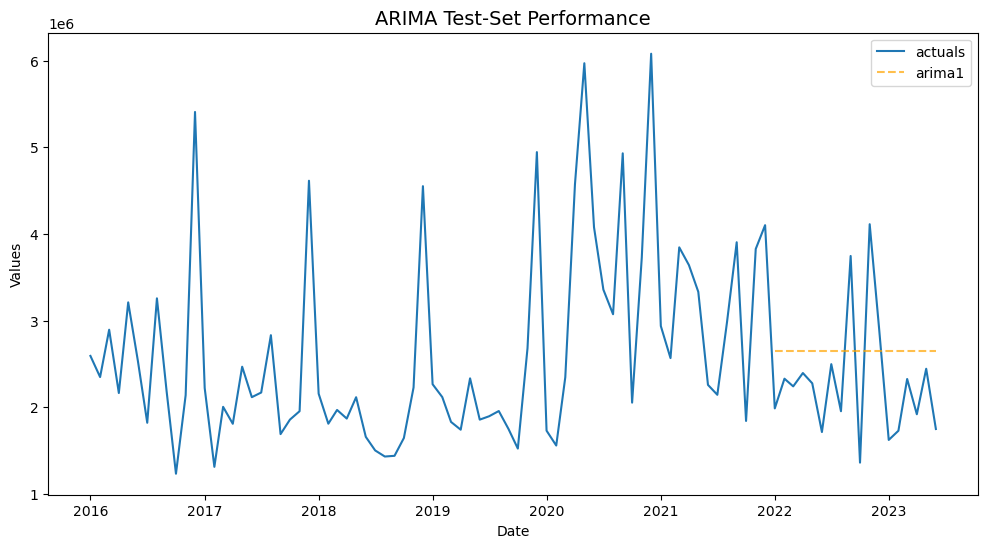

In [57]:
f = Forecaster(y=df_1_d['NET_SALES'],current_dates=df_1_d['MONTH'])

# this gives “naïve” forecast

f.generate_future_dates(12) # 12-month forecast horizon
f.set_test_length(.2) # 20% test set
f.set_estimator('arima') # set arima
f.manual_forecast(call_me='arima1') # forecast with arima

f.plot_test_set(ci=True) # view test results
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

# Automation

Use Grid search the optimal orders in scalecast

c:\Users\crudek\AppData\Local\anaconda3\Lib\site-packages\scalecast\_utils.py:60: Warning: Confidence intervals not found for arima4. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(


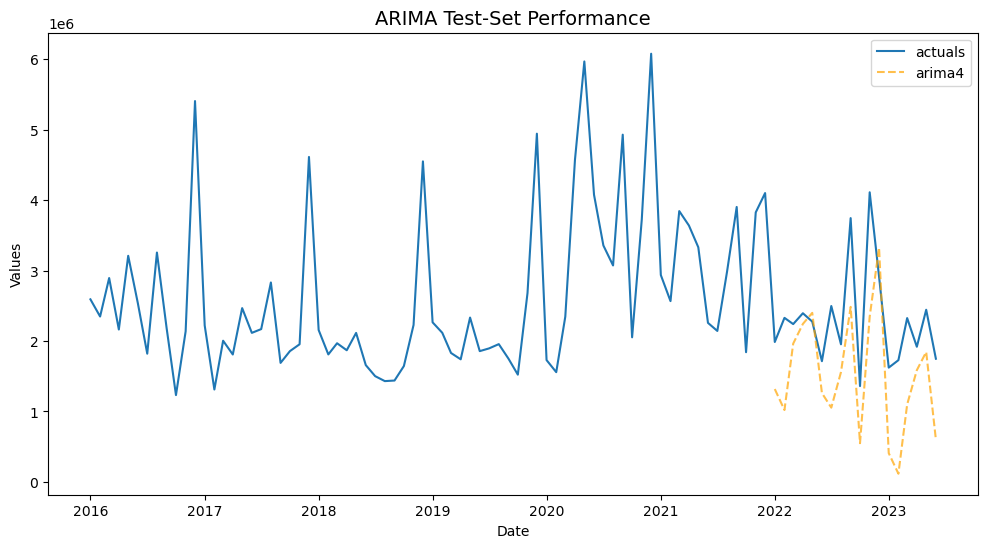

c:\Users\crudek\AppData\Local\anaconda3\Lib\site-packages\scalecast\_utils.py:60: Warning: Confidence intervals not found for arima4. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(


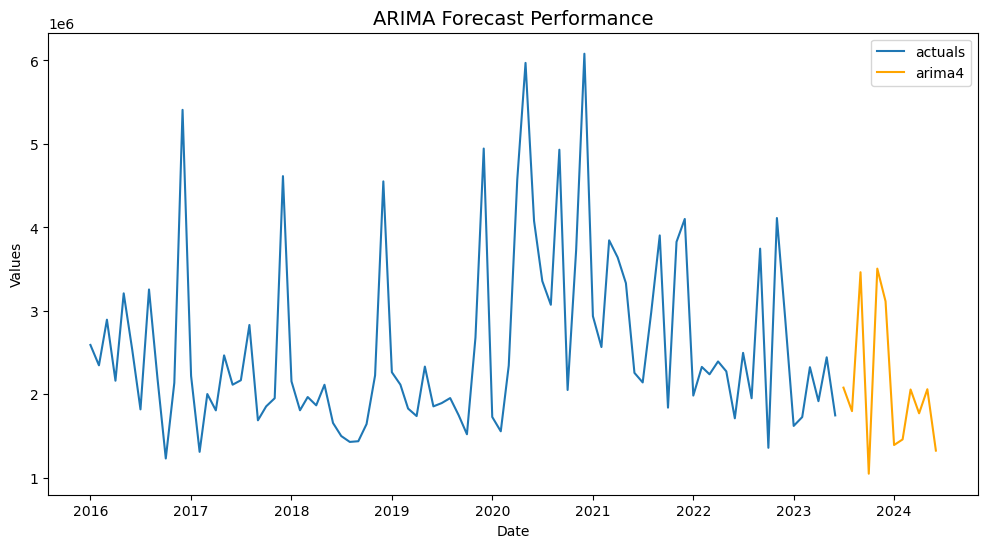

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   90
Model:             ARIMA(0, 1, 1)x(2, 1, [], 12)   Log Likelihood               -1157.765
Date:                           Tue, 15 Aug 2023   AIC                           2323.529
Time:                                   18:11:19   BIC                           2332.904
Sample:                                        0   HQIC                          2327.279
                                            - 90                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2911      0.078     -3.752      0.000      -0.443      -0.139
ar.S.L12      -0.3204      0.108     -2.978      0.003      -0.531      -0.110
ar.S.L24      -0.1612      0.163     -0.988      0.323      -0.481       0.158
sigma2      7.459e+11   1.11e-14   6.72e+25      0.000    7.46e+11    7.46e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.54   Jarque-Bera (JB):                 7.65
Prob(Q):                              0.46   Prob(JB):                         0.02
Heteroskedasticity (H):               2.26   Skew:                            -0.09
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.74e+42. Standard errors may be unstable.
"""

In [74]:
f.set_validation_length(1)
grid = {
    'order':[(1,1,1),(1,1,0),(0,1,1)],
    'seasonal_order':[(2,1,1,12),(1,1,1,12),(2,1,0,12),(0,1,0,12)]
}

f.ingest_grid(grid)
f.tune()
f.auto_forecast(call_me='arima4')

f.plot_test_set(ci=True,models='arima4')
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

f.plot(ci=True,models='arima4')
plt.title('ARIMA Forecast Performance',size=14)
plt.show()

f.regr.summary()

# Automation 2

Set orders with pmdarima’s auto_arima function

In [63]:
from scalecast.auxmodels import auto_arima

In [75]:
auto_arima(
    f,
    m=12,
    call_me='arima3',
)

c:\Users\crudek\AppData\Local\anaconda3\Lib\site-packages\scalecast\_utils.py:60: Warning: Confidence intervals not found for arima3. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(


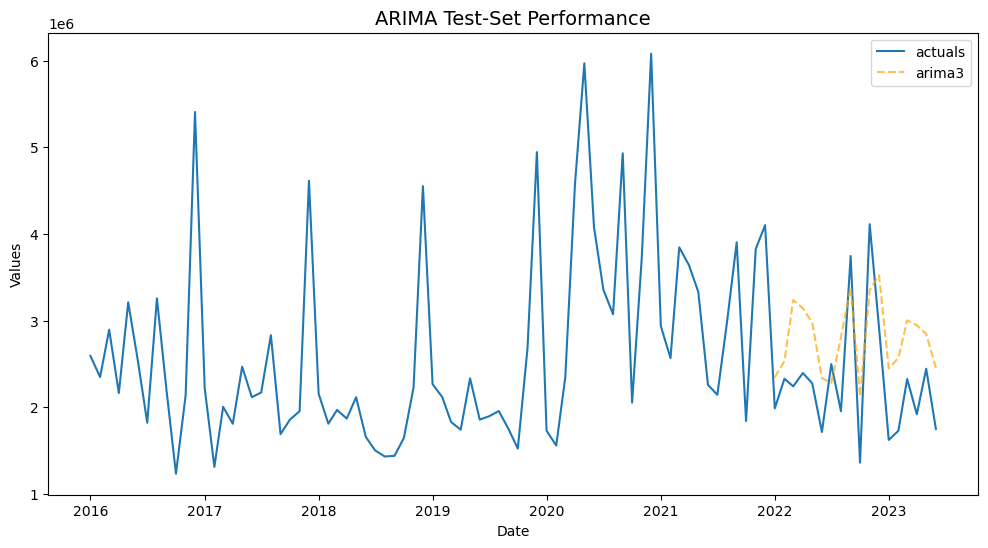

In [76]:
f.plot_test_set(ci=True,models='arima3')
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

c:\Users\crudek\AppData\Local\anaconda3\Lib\site-packages\scalecast\_utils.py:60: Warning: Confidence intervals not found for arima3. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(


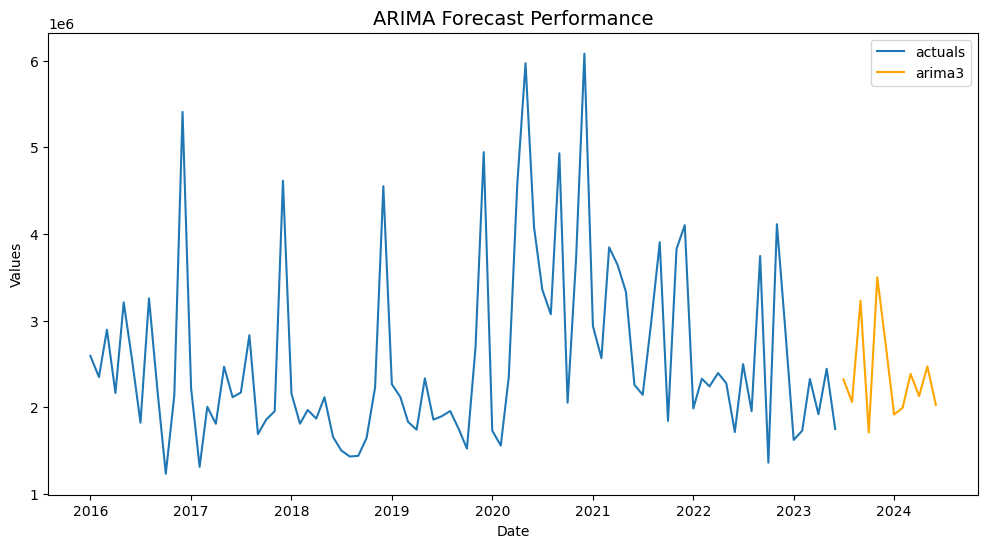

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   90
Model:             ARIMA(1, 0, 3)x(1, 0, [], 12)   Log Likelihood               -1355.026
Date:                           Tue, 15 Aug 2023   AIC                           2724.053
Time:                                   18:18:13   BIC                           2741.551
Sample:                                        0   HQIC                          2731.109
                                            - 90                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.581e+06   1.26e+06      2.054      0.040    1.19e+05    5.04e+06
ar.L1          0.8175      0.347      2.359      0.018       0.138       1.497
ma.L1         -0.3882      0.385     -1.008      0.313      -1.143       0.367
ma.L2         -0.1496      0.288     -0.520      0.603      -0.714       0.414
ma.L3          0.0413      0.265      0.156      0.876      -0.478       0.561
ar.S.L12       0.6456      0.116      5.564      0.000       0.418       0.873
sigma2      9.868e+11      3.572   2.76e+11      0.000    9.87e+11    9.87e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                41.68
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                             1.17
Prob(H) (two-sided):                  0.66   Kurtosis:                         5.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.4e+26. Standard errors may be unstable.
"""

In [78]:
f.plot(ci=True,models='arima3')
plt.title('ARIMA Forecast Performance',size=14)
plt.show()

f.regr.summary()

* [Example](https://towardsdatascience.com/forecast-with-arima-in-python-more-easily-with-scalecast-35125fc7dc2e#:~:text=An%20Autoregressive%20Integrated%20Moving%20Average,statistical%20properties%20of%20the%20data.)

* [Scalecast documentation](https://scalecast-examples.readthedocs.io/en/latest/arima/arima.html)